## Exercise 4.7 (programming)

Write a program for policy iteration and re-solve Jack's car rental problem with the following changes. One of Jack's employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle `one car` to the second location for free. Each additional car still `costs $2`, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If `more than 10 cars` are kept overnight at a location (after any moving of cars), then an `additional cost of $4` must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import os

current_dir = os.path.abspath(os.path.dirname(__file__))

MAX_CAR_LIMIT = 20  # maximum # of cars in each location
MAX_MOVE_LIMIT = 5   # maximum # of cars to move during night
EXP_REQ_1 = 3       # expectation of rental requests in 1st location
EXP_REQ_2 = 4       # expectation of rental requests in 2nd location
EXP_RET_1 = 3       # expectation of # of cars returned in 1st location
EXP_RET_2 = 2       # expectation of # of cars returned in 2nd location

stateValue = np.zeros((MAX_CAR_LIMIT + 1, MAX_CAR_LIMIT + 1))       # state value
policy = np.zeros(stateValue.shape, dtype = int)                    # store action taken of each state

DISCOUNT = 0.9

RENTAL_CREDIT = 10      # rental credit earned by a car
MOVE_CAR_COST = 2       # cost of moving a car

PARKING_EXTRA_COST = 4  # cost of second parking lot

actions = np.arange(-MAX_MOVE_LIMIT, MAX_MOVE_LIMIT + 1)    # action space is whether to move a car

POISSON_UPPER_BOUND = 12        # If n is greater than 12, then the probability of getting n is truncated to 0.
poisson_cache = dict()          # store probability to ensure consistency

def poisson_prob(n: int, expectation: int):
    global poisson_cache
    key = f"n{n}e{expectation}"
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, expectation)
    
    return poisson_cache[key]


def get_return(state, action, stateValue, constantReturnedCars: bool = True) -> int:
    """
    param: state:  [# of cars in 1st location, # of cars in 2nd location]
    param: action: whether to move a car or not,
            positive if `1st location -> 2nd location`
            negative if `1st location <- 2nd location`
    param: stateValue: a matrix with size `(MAX_CAR_LIMIT + 1, MAX_CAR_LIMIT + 1)` storing stateValue
    param: constantReturnedCars: whether to simplify problem by asigning returned cars to constant number

    return: returns
    """
    returns = 0.0   # initialize total return
    returns -= MOVE_CAR_COST * (action - 1) if action > 0 else MOVE_CAR_COST * abs(action)  # cost of moving a car

    # number of cars after moving
    num_of_cars_1 = min(state[0] - action, MAX_CAR_LIMIT)
    num_of_cars_2 = min(state[1] + action, MAX_CAR_LIMIT)

    # extra cost
    returns -= ((4 if num_of_cars_1 > 10 else 0) + (4 if num_of_cars_2 > 10 else 0))

    # sweep through all possible rental request
    for request_1_loc in range(POISSON_UPPER_BOUND + 1):
        for request_2_loc in range(POISSON_UPPER_BOUND + 1):
            prob_request = poisson_prob(request_1_loc, EXP_REQ_1) * \
            poisson_prob(request_2_loc, EXP_REQ_2)

            valid_retal_1 = min(num_of_cars_1, request_1_loc)
            valid_retal_2 = min(num_of_cars_2, request_2_loc)

            # get rental credits for renting
            reward = (valid_retal_1 + valid_retal_2) * RENTAL_CREDIT
            res_cars_1 = num_of_cars_1 - valid_retal_1
            res_cars_2 = num_of_cars_2 - valid_retal_2

            # returned cars
            if constantReturnedCars:
                res_cars_1 = min(res_cars_1 + EXP_RET_1, MAX_CAR_LIMIT)
                res_cars_2 = min(res_cars_2 + EXP_RET_2, MAX_CAR_LIMIT)
                returns += prob_request * (reward + DISCOUNT * stateValue[res_cars_1, res_cars_2])
            
            else:
                for returned_cars_1_loc in range(POISSON_UPPER_BOUND + 1):
                    for returned_cars_2_loc in range(POISSON_UPPER_BOUND + 1):
                        prob_return = poisson_prob(returned_cars_1_loc, EXP_RET_1) * \
                        poisson_prob(returned_cars_2_loc, EXP_RET_2)

                        res_cars_1 = min(res_cars_1 + returned_cars_1_loc, MAX_CAR_LIMIT)
                        res_cars_2 = min(res_cars_2 + returned_cars_2_loc, MAX_CAR_LIMIT)

                        prob = prob_request * prob_return

                        returns += prob * (reward + DISCOUNT * stateValue[res_cars_1, res_cars_2])
    
    return returns


def policy_iteration():
    iterations = 0
    _, axes = plt.subplots(2, 3, figsize = (40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    while True:
        fig = sns.heatmap(np.flipud(policy), cmap = 'YlGnBu', ax = axes[iterations])
        fig.set_ylabel('# cars at 1st location', fontsize = 30)
        fig.set_yticks(list(reversed(range(MAX_CAR_LIMIT + 1))))
        fig.set_xlabel('# cars at 2nd location', fontsize = 30)
        fig.set_title('policy {}'.format(iterations), fontsize = 30)

        # policy evaluation (in-place)
        while True:
            old_value = stateValue.copy()
            for i in range(MAX_CAR_LIMIT + 1):
                for j in range(MAX_CAR_LIMIT + 1):
                    update_stateValue = get_return([i, j], policy[i, j], stateValue)
                    stateValue[i, j] = update_stateValue
            
            max_value_change = abs(old_value - stateValue).max()
            print('max value chagne {}'.format(max_value_change))
            if max_value_change < 1e-4:
                break

        # policy improvement
        policy_stable = True
        for i in range(MAX_CAR_LIMIT + 1):
            for j in range(MAX_CAR_LIMIT + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(get_return([i, j], action, stateValue))
                    else:
                        action_returns.append(-np.inf)
                
                update_action = actions[np.argmax(action_returns)]
                policy[i, j] = update_action
                if policy_stable and old_action != update_action:
                    policy_stable = False
        
        print('policy state {}'.format(policy_stable))

        if policy_stable:
            fig = sns.heatmap(np.flipud(stateValue), cmap = 'YlGnBu', ax = axes[-1])
            fig.set_ylabel('# cars at 1st location', fontsize = 30)
            fig.set_yticks(list(reversed(range(MAX_CAR_LIMIT + 1))))
            fig.set_xlabel('# cars at 2nd location', fontsize = 30)
            fig.set_title('optimal value', fontsize = 30)
            break

        iterations += 1
    
    plt.savefig(f'{current_dir}/policyIteration.png')
    plt.show()
    plt.close()

    def addSubplot(ax, data, label):
        AxisZ = []
        AxisXPrint, AxisYPrint = [], []
        for i in range(MAX_CAR_LIMIT + 1):
            for j in range(MAX_CAR_LIMIT + 1):
                AxisXPrint.append(i)
                AxisYPrint.append(j)
                AxisZ.append(data[i, j])

        ax.scatter(AxisXPrint, AxisYPrint, AxisZ)
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.set_zlabel(label[2])
    
    def gen3d(policy, stateValue):
        fig = plt.figure(figsize = (14, 6))
        ax1 = fig.add_subplot(121, projection = '3d')
        ax2 = fig.add_subplot(122, projection = '3d')
        
        addSubplot(ax1, policy, ['# of cars in 1st location', '# of cars in 2nd location','# of cars to move during night'])
        addSubplot(ax2, stateValue, ['# of cars in 1st location', '# of cars in 2nd location','expected returns'])
        plt.savefig(f'{current_dir}/exp-3d.png')  
        plt.show()
    
    gen3d(policy, stateValue)



max value chagne 177.07228886484506
max value chagne 122.97157311246413
max value chagne 84.66677196428535
max value chagne 66.09948371696262
max value chagne 51.21954402850906
max value chagne 38.85849423223516
max value chagne 30.0534574402366
max value chagne 26.335718532293782
max value chagne 22.950534634930676
max value chagne 19.924014643325506
max value chagne 17.24903175740286
max value chagne 14.90260451529781
max value chagne 12.855097317198954
max value chagne 11.075079520663508
max value chagne 9.53185178776954
max value chagne 8.19670115050701
max value chagne 7.043452101255411
max value chagne 6.048626552459723
max value chagne 5.1913910250409
max value chagne 4.4533945120798535
max value chagne 3.8185568326184125
max value chagne 3.272841390276824
max value chagne 2.80403091327031
max value chagne 2.401515788530105
max value chagne 2.056099452973399
max value chagne 1.7598224028227492
max value chagne 1.5058047862452213
max value chagne 1.2881067009467984
max value chag

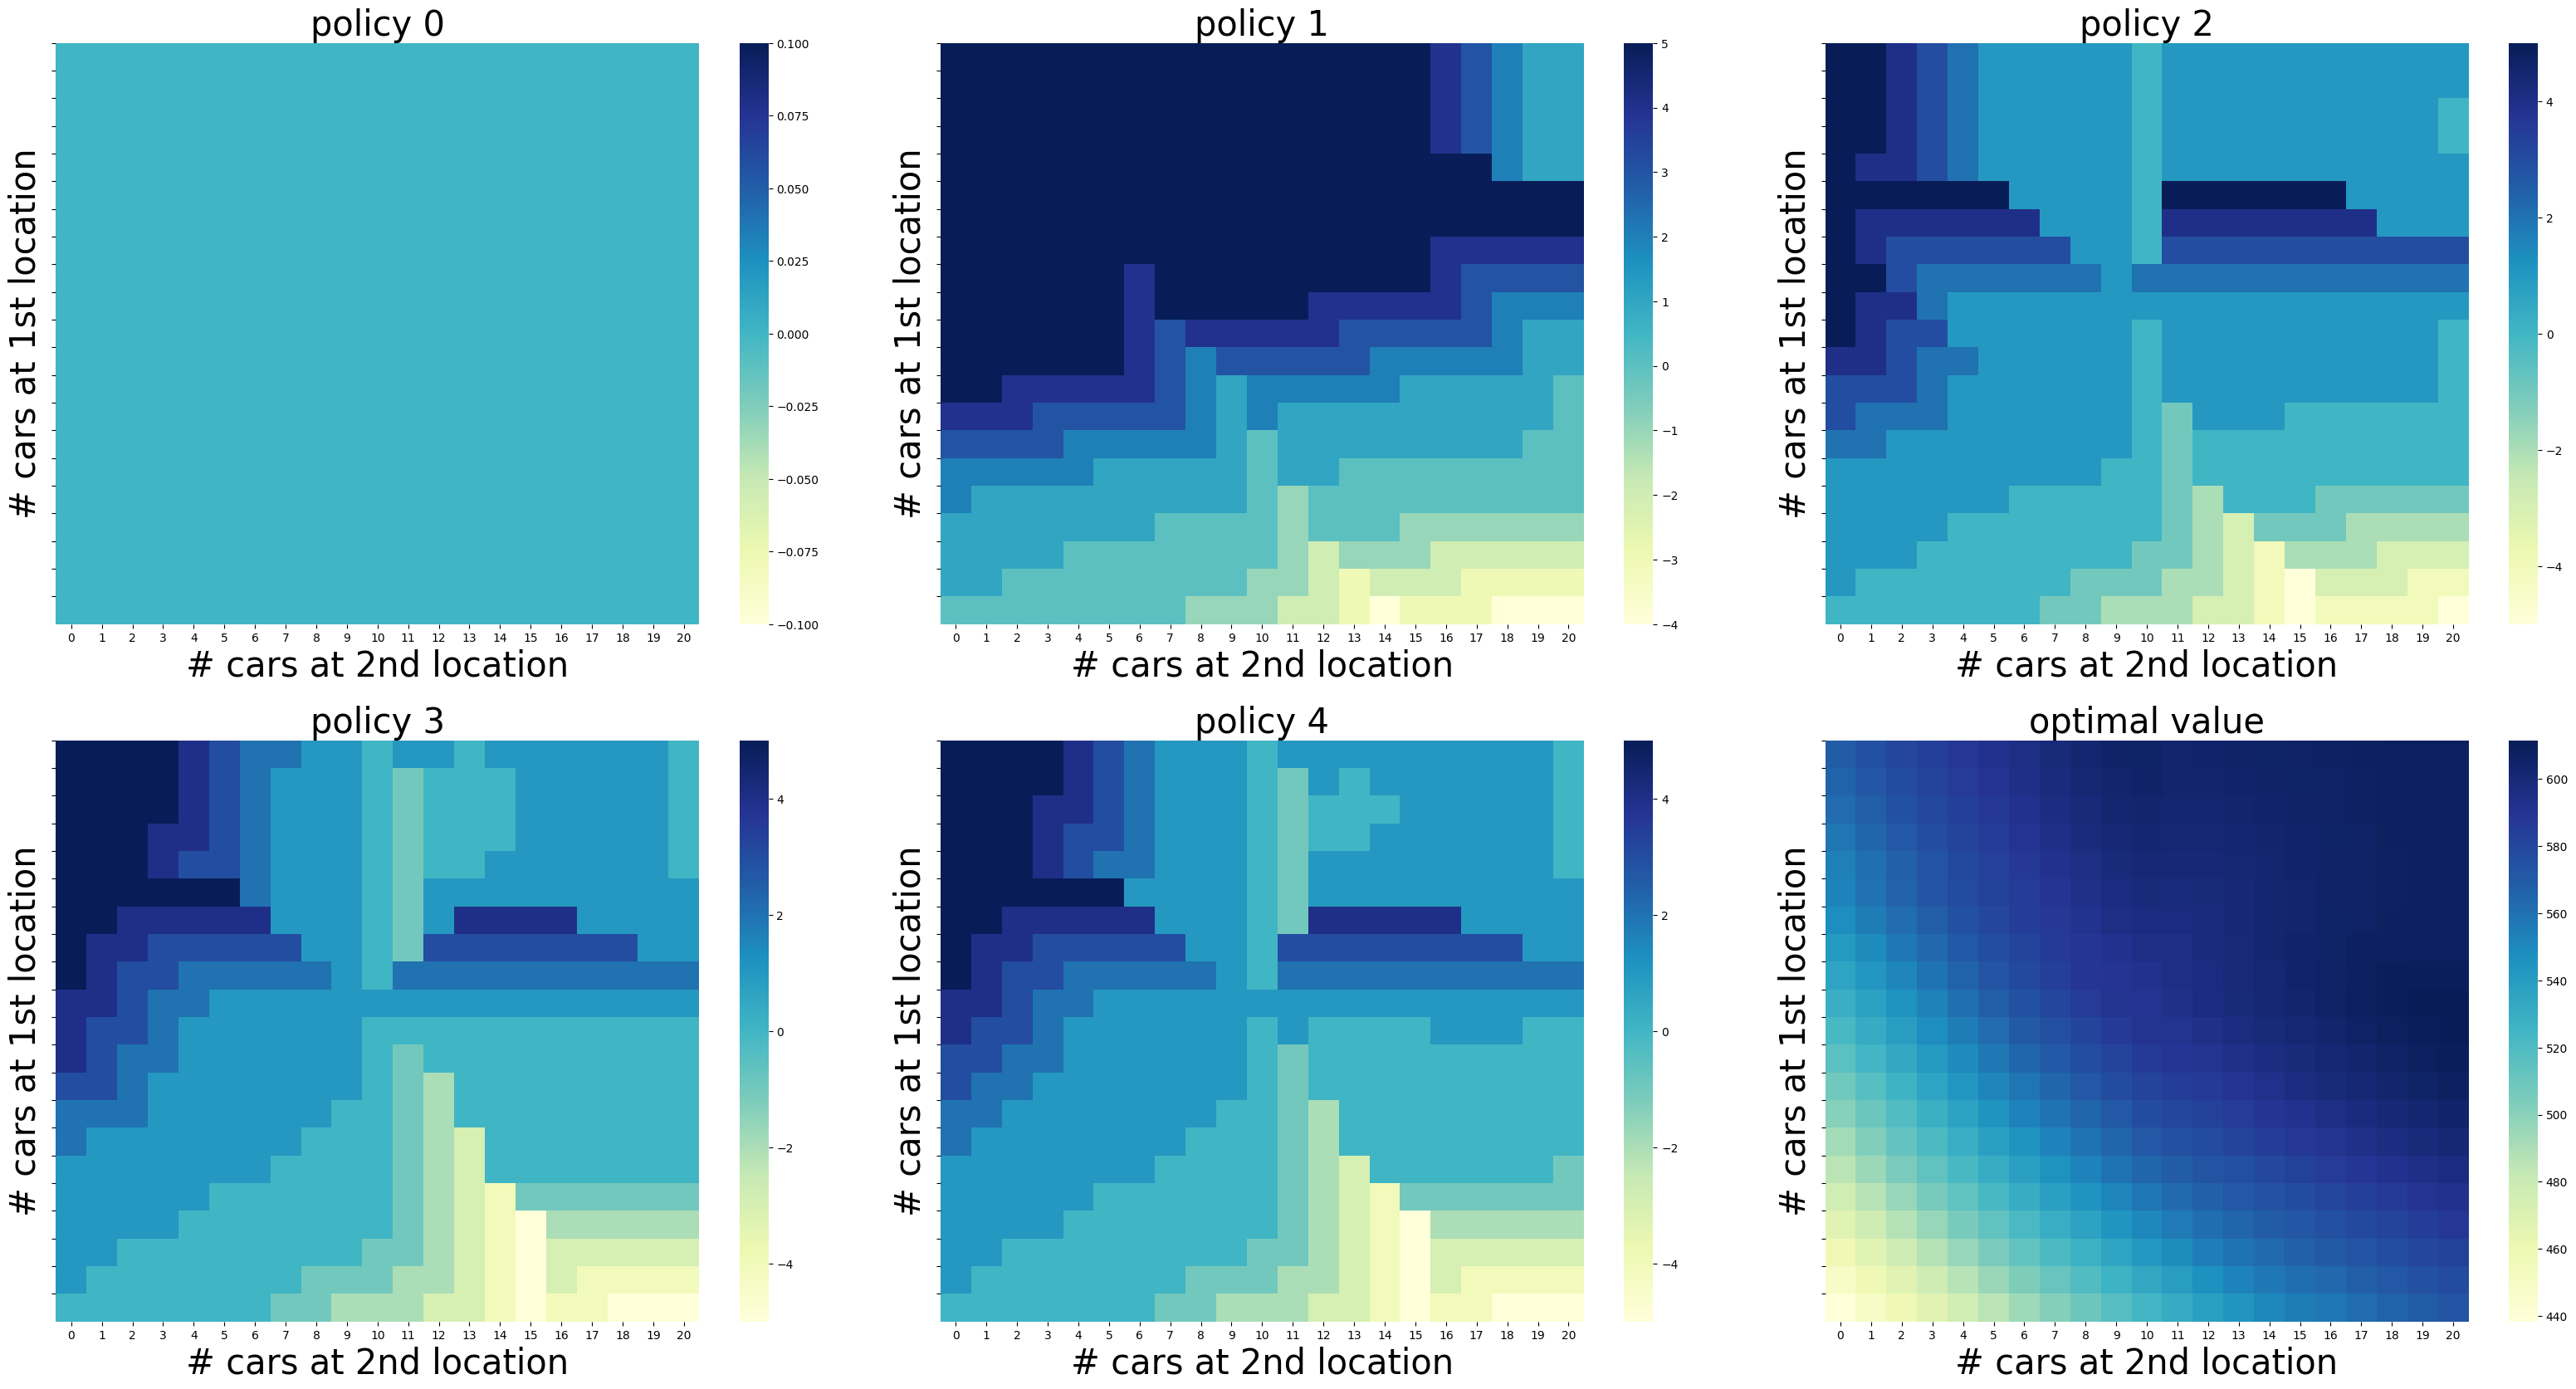

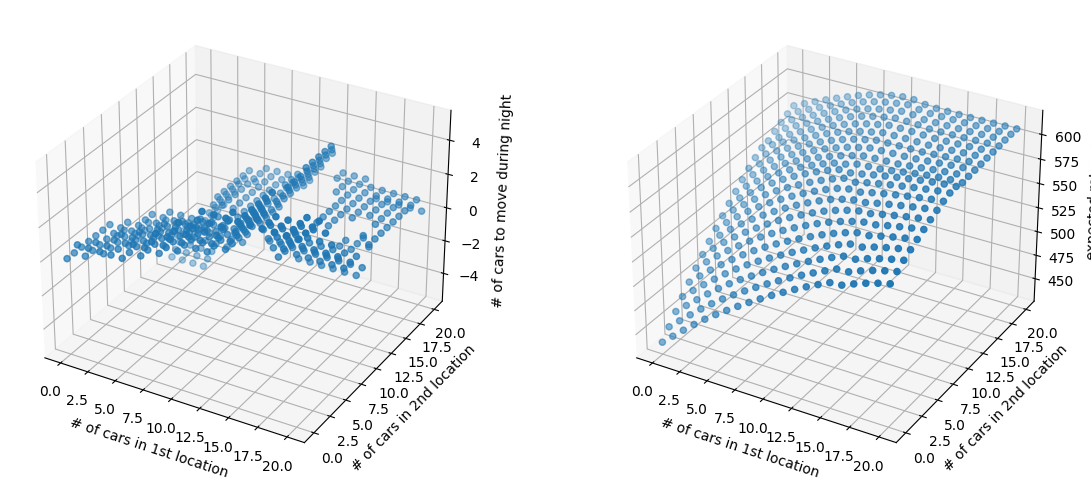

In [7]:
policy_iteration()